In [1]:
%matplotlib inline
import torch as tc
import tensorflow as tf
import mxnet as mx
from mxnet import np as mxnp
from mxnet import npx as npx
npx.set_np()
# import numpy as np

from d2l import mxnet as mxd2l  # Use MXNet as the backend
from d2l import torch as tcd2l  # Use PyTorch as the backend
from d2l import tensorflow as tfd2l  # Use TensorFlow as the backend

tc.__version__,tf.__version__,mx.__version__

('1.6.0', '2.3.1', '1.7.0')

In [53]:
data_file_path=r'../data/cmn-eng/cmn_1.txt'
def read_data_nmt(path=data_file_path):
    with open(path,'r',encoding='utf-8') as f:
        next(f)
        return f.read()

In [54]:
raw_text = read_data_nmt()
print(raw_text[:100])

Hi.	嗨。
Hi.	你好。
Run.	你用跑的。
Wait!	等等！
Wait!	等一下！
Hello!	你好。
I won!	我赢了。
Oh no!	不会吧。
Cheers!	乾杯!
Got it


In [55]:
def no_space(char, prev_char):
    return char in set(',.!?') and prev_char != ' '  #set(',.!?，。！？')

In [56]:
print('b','\u202f','\xa0','e')

b     e


In [57]:
def preprocess_nmt(raw_text):
    text=raw_text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out=[' '+char if (i>0 and no_space(char,text[i-1])) else char for i,char in enumerate(text)]
    return ''.join(out)

In [58]:
text = preprocess_nmt(raw_text)

In [62]:
# print(text[0:800])

In [ ]:
import re
def get_word_list(s1):
    # 把句子按字分开，中文按字分，英文按单词，数字按空格
    res = re.compile(r"([\u4e00-\u9fa5，、。！？])")  # [\u4e00-\u9fa5]中文范围,以及中文符号“，、。！？”拆分
    p1 = res.split(s1.lower())
    str1_list = []
    for seg in p1:
        str1_list=str1_list+(seg.split(' '))
    list_word1 = [w for w in str1_list if len(w.strip()) > 0]  # 去掉为空的字符
    return list_word1

In [257]:
def tokenize_nmt(text,num_examples=None):
    zh_source,en_target=[],[]
    for i,line in enumerate(text.split('\n')):
        if num_examples is not None and i>num_examples:
            break
#         print(i,line)
        parts=line.split('\t')
        if len(parts)==2:
            zh_source.append(get_word_list(parts[1]))
            en_target.append(get_word_list(parts[0]))
#             zh_source.append(list(parts[1]))
#             en_target.append(parts[0].split(' '))
    return zh_source,en_target

In [258]:
zh_source,en_target = tokenize_nmt(text)

In [259]:
len(zh_source),len(en_target)

(24026, 24026)

In [260]:
"".join(zh_source[24025])," ".join(en_target[24025])

('如果一個人在成人前沒有機會習得目標語言，他對該語言的認識達到母語者程度的機會是相當小的。',
 '"if a person has not had a chance to acquire his target language by the time he\'s an adult , he\'s unlikely to be able to reach native speaker level in that language ."')

In [267]:
# zh_source
# en_target

In [262]:
"Flowers bloom.	鮮花盛開。".split('\t')

['Flowers bloom.', '鮮花盛開。']

In [263]:
len("Flowers bloom.	鮮花盛開。".split('\t'))

2

In [264]:
text[:100].split('\n')

['hi .\t嗨。',
 'hi .\t你好。',
 'run .\t你用跑的。',
 'wait !\t等等！',
 'wait !\t等一下！',
 'hello !\t你好。',
 'i won !\t我赢了。',
 'oh no !\t不会吧。',
 'cheers !\t乾']

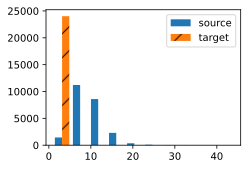

In [268]:
d2l=mxd2l
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in zh_source], [len(l) for l in en_target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

In [97]:
src_vocab = d2l.Vocab(zh_source, min_freq=2,reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

2878

In [107]:
tgt_vocab = d2l.Vocab(en_target, min_freq=2,reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(tgt_vocab)

4214

In [108]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[zh_source[0]], 10, src_vocab['<pad>'])

[1985, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [109]:
src_vocab.to_tokens([1985, 4, 1, 1, 1, 1, 1, 1, 1, 1])

['嗨',
 '。',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [115]:
truncate_pad(tgt_vocab[en_target[0]], 10, tgt_vocab['<pad>'])

[1876, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [116]:
tgt_vocab.to_tokens([1876, 4, 1, 1, 1, 1, 1, 1, 1, 1])

['hi',
 '.',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [117]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = d2l.reduce_sum(
        d2l.astype(array != vocab['<pad>'], np.int32), 1)
    return array, valid_len

In [269]:
#@save
np=mxnp
def load_data_nmt(batch_size, num_steps, num_examples=None):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab,source, target

In [270]:
train_iter, src_vocab, tgt_vocab,source, target = load_data_nmt(batch_size=2, num_steps=12)

In [271]:
len(source),len(target)

(24026, 24026)

In [272]:
source[0:10],target[0:10]

([['嗨', '。'],
  ['你', '好', '。'],
  ['你', '用', '跑', '的', '。'],
  ['等', '等', '！'],
  ['等', '一', '下', '！'],
  ['你', '好', '。'],
  ['我', '赢', '了', '。'],
  ['不', '会', '吧', '。'],
  ['乾', '杯', ' !'],
  ['你', '懂', '了', '吗', '？']],
 [['hi .'],
  ['hi .'],
  ['run .'],
  ['wait !'],
  ['wait !'],
  ['hello !'],
  ['i won !'],
  ['oh no !'],
  ['cheers !'],
  ['got it ?']])

In [283]:
i=0
for X, X_valid_len, Y, Y_valid_len in train_iter:
  
    X=X.astype(np.int32).asnumpy()
    Y=Y.astype(np.int32).asnumpy()
    
#     print('X:', X.astype(np.int32))    
#     print('valid lengths for X:', X_valid_len)    
#     print('Y:', Y.astype(np.int32))
#     print('valid lengths for Y:', Y_valid_len)
    print("---"*30)
    print(src_vocab.to_tokens(list(X[0])),tgt_vocab.to_tokens(list(Y[0])))
    print(src_vocab.to_tokens(list(X[1])),tgt_vocab.to_tokens(list(Y[1])))
    print("---"*30)
    i+=1
    if i==5:
        break

------------------------------------------------------------------------------------------
['我', '只', '想', '到', '你', '。', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] ['<unk>', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['他', '以', '教', '書', '為', '生', '。', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>'] ['he earned his living as a teacher .', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
['他', '不', '可', '能', '成', '功', '。', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>'] ['<unk>', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['我', '希', '望', '湯', '姆', '能', '同', '意', '。', '<eos>', '<pad>', '<pad>'] ['<unk>', '<eos>', '<pad>', '<pad>', '<pad>', '<pa

In [285]:
src_vocab.token_freqs 

[('。', 20107),
 ('我', 10738),
 ('的', 7102),
 ('了', 5225),
 ('你', 5016),
 ('他', 4265),
 ('不', 3326),
 ('是', 3284),
 ('一', 3147),
 ('在', 3067),
 ('？', 3039),
 ('有', 2515),
 ('姆', 2411),
 ('她', 1869),
 ('，', 1550),
 ('汤', 1547),
 ('很', 1541),
 ('要', 1533),
 ('這', 1448),
 ('人', 1409),
 ('这', 1349),
 ('們', 1313),
 ('天', 1280),
 ('到', 1258),
 ('去', 1227),
 ('上', 1214),
 ('個', 1187),
 ('个', 1147),
 ('们', 1139),
 ('想', 1136),
 ('好', 1079),
 ('什', 1077),
 ('那', 1076),
 ('能', 1026),
 ('么', 1008),
 ('子', 987),
 ('嗎', 982),
 ('看', 927),
 ('做', 905),
 ('湯', 879),
 ('吗', 846),
 ('得', 836),
 ('多', 827),
 ('下', 776),
 ('道', 741),
 ('麼', 721),
 ('生', 716),
 ('会', 709),
 ('知', 700),
 ('會', 696),
 ('可', 690),
 ('都', 686),
 ('没', 684),
 ('来', 679),
 ('以', 667),
 ('裡', 666),
 ('喜', 653),
 ('來', 634),
 ('大', 627),
 ('把', 620),
 ('家', 617),
 ('事', 603),
 ('起', 556),
 ('就', 552),
 ('沒', 543),
 ('说', 539),
 ('时', 524),
 ('作', 517),
 ('和', 496),
 ('吃', 495),
 ('里', 484),
 ('为', 479),
 ('為', 474),
 ('本', 472),
 

In [281]:
import re

In [204]:
r = re.compile('[^\u4e00-\u9fa5]')

In [226]:
w="John比Tom Marry年轻得多"

In [227]:
r.search(w)

<re.Match object; span=(0, 1), match='J'>

In [228]:
print(re.findall('[^\u4e00-\u9fa5].*', w))


['John比Tom Marry年轻得多']


In [231]:
result_list = re.findall('[a-zA-Z0-9]+',w)
result_list

['John', 'Tom', 'Marry']

In [235]:
w,w.index('Marry')

('John比Tom Marry年轻得多', 9)

In [209]:
import re

data = """我始终！@@##¥%…………&alkjdfsb1234\n
566667是中国人woaldsfkjzlkcjxv123*())<>
"""

# 匹配所有汉字
print(re.findall('[\u4e00-\u9fa5]', data))

# 匹配所有单字符，英文，数字，特殊符号
print(re.findall('[\x00-\xff]', data))

# 匹配所有非单字符，入汉字和省略号
print(re.findall('[^\x00-\xff]', data))

['我', '始', '终', '是', '中', '国', '人']
['@', '@', '#', '#', '¥', '%', '&', 'a', 'l', 'k', 'j', 'd', 'f', 's', 'b', '1', '2', '3', '4', '\n', '\n', '5', '6', '6', '6', '6', '7', 'w', 'o', 'a', 'l', 'd', 's', 'f', 'k', 'j', 'z', 'l', 'k', 'c', 'j', 'x', 'v', '1', '2', '3', '*', '(', ')', ')', '<', '>', '\n']
['我', '始', '终', '！', '…', '…', '…', '…', '是', '中', '国', '人']


In [211]:
re.findall??

Signature: re.findall(pattern, string, flags=0)
Source:   
def findall(pattern, string, flags=0):
    """Return a list of all non-overlapping matches in the string.

    If one or more capturing groups are present in the pattern, return
    a list of groups; this will be a list of tuples if the pattern
    has more than one group.

    Empty matches are included in the result."""
    return _compile(pattern, flags).findall(string)
File:      c:\users\hp\miniconda3\envs\d2l\lib\re.py
Type:      function


In [255]:
def get_word_list(s1):
    # 把句子按字分开，中文按字分，英文按单词，数字按空格
    regEx = re.compile('[\\W]*')    # 我们可以使用正则表达式来切分句子，切分的规则是除单词，数字外的任意字符串
    res = re.compile(r"([\u4e00-\u9fa5])")    #  [\u4e00-\u9fa5]中文范围
#     res = re.compile(r'^[a-zA-Z0-9]+') 
    
#     print(res.split(s1) )

#     p1 = regEx.split(s1.lower())
    p1 = res.split(s1.lower())
    str1_list = []
    for str in p1:
        if res.split(str) == None:
            str1_list.append(str)
        else:
            ret = res.split(str)
            for ch in ret:
                str1_list.append(ch)

    list_word1 = [w for w in str1_list if len(w.strip()) > 0]  # 去掉为空的字符

    return  list_word1


if __name__ == '__main__':
    s = "12、China's Legend Holdings will split its several business arms to go public on stock markets,  the group's president Zhu Linan said on Tuesday.该集团总裁朱利安周二表示，haha中国联想控股将分拆其多个业务部门在股市上市。"
    list_word1=get_word_list(s)
    list_word2=get_word_list(w)
    print(list_word1)
    print("\n")
    print(list_word2)


["12、china's legend holdings will split its several business arms to go public on stock markets,  the group's president zhu linan said on tuesday.", '该', '集', '团', '总', '裁', '朱', '利', '安', '周', '二', '表', '示', '，haha', '中', '国', '联', '想', '控', '股', '将', '分', '拆', '其', '多', '个', '业', '务', '部', '门', '在', '股', '市', '上', '市', '。']


['john', '比', 'tom marry', '年', '轻', '得', '多']


In [243]:
import re
s = 'hi新手oh' #举个栗子是字符串s，为了匹配下文的unicode形式，所以需要解码
p = re.compile('[\u4e00-\u9fa5]') #这里是精髓，[\u4e00-\u9fa5]是匹配所有中文的正则，因为是unicode形式，所以也要转为ur
  
print(p.split(s) )

['hi', '', 'oh']


In [256]:
str.split??

Signature: str.split(self, /, sep=None, maxsplit=-1)
Docstring:
Return a list of the words in the string, using sep as the delimiter string.

sep
  The delimiter according which to split the string.
  None (the default value) means split according to any whitespace,
  and discard empty strings from the result.
maxsplit
  Maximum number of splits to do.
  -1 (the default value) means no limit.
Type:      method_descriptor
